<a href="https://colab.research.google.com/github/romanbash/DTSA-5509---final-project/blob/main/stroke_prediction_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/DTSA 5509 - final project/healthcare-dataset-stroke-data.csv'

Mounted at /content/drive


In [3]:
df = pd.read_csv(data_path)


In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.shape

(5110, 12)

The columns of our data are:

In [6]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

So we have 5100 entries and 12 columns - 11 optional features and the label column - *stroke*.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


##Attribute Information
1) **id**: unique identifier

2) **gender**: "Male", "Female" or "Other"

3) **age**: age of the patient

4) **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) **ever_married**: "No" or "Yes"

7) **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) **Residence_type**: "Rural" or "Urban"

9) **avg_glucose_level**: average glucose level in blood

10) **bmi**: body mass index

11) **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) **stroke**: 1 if the patient had a stroke or 0 if not

*Note*: "Unknown" in smoking_status means that the information is unavailable for this patient

In [8]:
missing_data = df.isnull().sum()

# Print the number of missing values in each column
print(missing_data)


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


The only not relevant column for now is the id column. It can not be a valuable feature beacuse it is just a random number. We should remove it.

In [9]:
df.drop('id', axis=1, inplace=True)

We see 201 rows with missing data in the BMI column. This is the only column with missing data. We need to handle this.

In order to choose the best way to impute missing data, we want to see the distribution of the data; we can attribute the missing values with mean, median, or mode. We will try to impute with a regration or k-nearest neighbors models. First, let's see the data distribution:

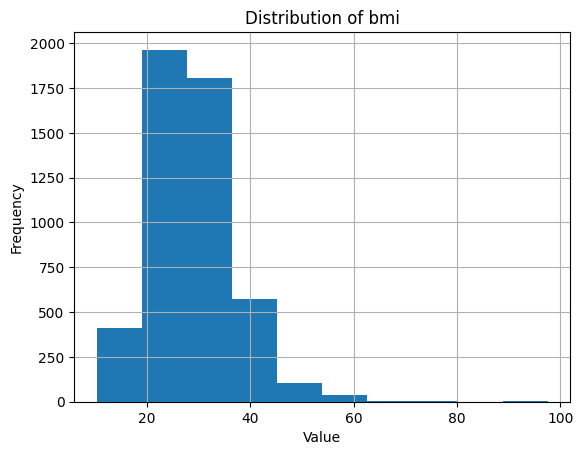

In [56]:
df['bmi'].hist()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of BMI')
plt.show()

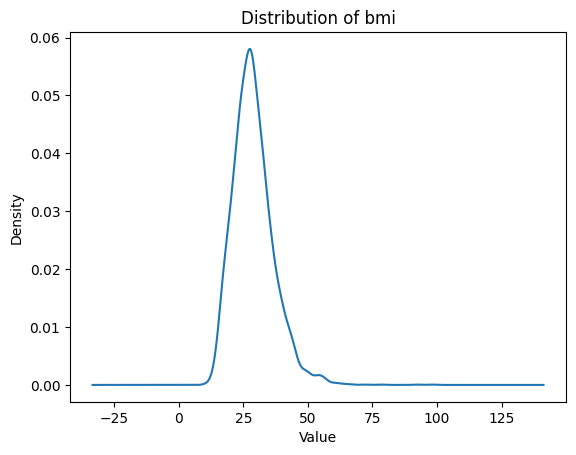

In [17]:
df['bmi'].plot.kde()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of BMI')
plt.show()

The distribution looks normal, we will perform the Shapiro-Wilk test.

In [57]:
# Perform a Shapiro-Wilk test
stat, p = shapiro(df['bmi'])
print('Shapiro-Wilk test results: statistic = %.3f, p-value = %.3f' % (stat, p))

# Interpret the results
if p > 0.05:
    print('The data is likely normally distributed.')
else:
    print('The data is not likely normally distributed.')

Shapiro-Wilk test results: statistic = nan, p-value = 1.000
The data is likely normally distributed.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


So the data is normally distributed. Let's handle the categorical columns and use SVM to impute the missing points.

In [10]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print the categorical columns
print(categorical_cols)


unique_values = {}
for col in categorical_cols:
    unique_values[col] = df[col].nunique()

# Print the number of unique values
print(unique_values)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')
{'gender': 3, 'ever_married': 2, 'work_type': 5, 'Residence_type': 2, 'smoking_status': 4}


These columns don't have a natural ordering, and the number of unique values is small, so we will use one hot encoding.

In [11]:
#binary columns:

df_encoded = pd.get_dummies(df, columns=['ever_married', 'Residence_type'], drop_first=True)

#molti values columns:
df_encoded = pd.get_dummies(df_encoded, columns=['work_type','smoking_status','gender', ])



df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   ever_married_Yes                5110 non-null   uint8  
 7   Residence_type_Urban            5110 non-null   uint8  
 8   work_type_Govt_job              5110 non-null   uint8  
 9   work_type_Never_worked          5110 non-null   uint8  
 10  work_type_Private               5110 non-null   uint8  
 11  work_type_Self-employed         5110 non-null   uint8  
 12  work_type_children              51

In [12]:
# Choose a regression model

model = LinearRegression()

df_dropped = df_encoded.dropna(axis=0)
X = df_dropped.drop(['bmi','stroke'], axis=1)
y = df_dropped['bmi']

# Train the model
model.fit(X, y)



LinearRegression()

In [13]:
# Predict the missing values

df_encoded_with_na = df_encoded[df_encoded['bmi'].isnull()]

df_encoded_with_na['bmi'] = model.predict(df_encoded_with_na.drop(['bmi','stroke'], axis=1))

df = pd.concat([df_dropped, df_encoded_with_na], ignore_index=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   ever_married_Yes                5110 non-null   uint8  
 7   Residence_type_Urban            5110 non-null   uint8  
 8   work_type_Govt_job              5110 non-null   uint8  
 9   work_type_Never_worked          5110 non-null   uint8  
 10  work_type_Private               5110 non-null   uint8  
 11  work_type_Self-employed         5110 non-null   uint8  
 12  work_type_children              51

<ipython-input-13-530758f58adf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_with_na['bmi'] = model.predict(df_encoded_with_na.drop(['bmi','stroke'], axis=1))


In [14]:
# prompt: i want to plot the corolation between columns

df.corr().style.background_gradient(cmap='coolwarm')


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
age,1.000000,0.276398,0.263796,0.238171,0.336922,0.245257,0.679125,0.014180,0.130013,-0.078653,0.116534,0.327989,-0.634215,-0.378231,0.236897,0.119307,0.073133,0.027924,-0.027623,-0.010659
hypertension,0.276398,1.000000,0.108306,0.174474,0.173416,0.127904,0.164243,-0.007913,0.017685,-0.021608,-0.005413,0.115442,-0.129506,-0.141501,0.058853,0.065063,0.031240,-0.021143,0.021275,-0.004597
heart_disease,0.263796,0.108306,1.000000,0.161857,0.042485,0.134914,0.114644,0.003092,0.001330,-0.015712,0.000027,0.086760,-0.091634,-0.066731,0.066804,-0.021856,0.044049,-0.085617,0.085717,-0.003343
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.180418,0.131945,0.155068,-0.004946,0.013845,-0.014675,0.016588,0.062694,-0.102250,-0.095131,0.068111,0.023885,0.017646,-0.054902,0.054580,0.011489
bmi,0.336922,0.173416,0.042485,0.180418,1.000000,0.043330,0.345786,-0.000864,0.079109,-0.028897,0.208924,0.072937,-0.453515,-0.271020,0.107069,0.105675,0.091067,0.024540,-0.024206,-0.011841
stroke,0.245257,0.127904,0.134914,0.131945,0.043330,1.000000,0.108340,0.015458,0.002677,-0.014882,0.011888,0.062168,-0.083869,-0.055892,0.064556,-0.004129,0.008939,-0.009027,0.009117,-0.003166
ever_married_Yes,0.679125,0.164243,0.114644,0.155068,0.345786,0.108340,1.000000,0.006261,0.134041,-0.090838,0.153830,0.192716,-0.544441,-0.332081,0.171256,0.102845,0.105226,0.030483,-0.029936,-0.019327
Residence_type_Urban,0.014180,-0.007913,0.003092,-0.004946,-0.000864,0.015458,0.006261,1.000000,0.013131,0.022859,-0.018173,0.010594,-0.002309,-0.002036,0.007654,-0.024466,0.027266,0.006340,-0.005937,-0.014217
work_type_Govt_job,0.130013,0.017685,0.001330,0.013845,0.079109,0.002677,0.134041,0.013131,1.000000,-0.025258,-0.444420,-0.167810,-0.151383,-0.097418,0.029686,0.046908,0.030026,0.016685,-0.016534,-0.005374
work_type_Never_worked,-0.078653,-0.021608,-0.015712,-0.014675,-0.028897,-0.014882,-0.090838,0.022859,-0.025258,1.000000,-0.076081,-0.028728,-0.025915,0.008804,-0.030095,0.036238,-0.028099,-0.011469,0.011496,-0.000920


We can see a feature that is highly corolated to stroke. Lets plot the stroke numbers to see if the dataset is balanced.

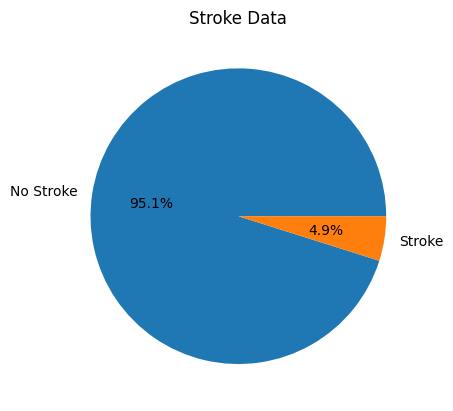

In [15]:
stroke_counts = df['stroke'].value_counts()
stroke_percentages = stroke_counts / len(df) * 100


lt.pie(stroke_percentages, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%')
plt.title('Stroke Data')
plt.show()

The data set is highly unbalanced.



In [22]:
data = pd.read_csv(data_path)
data.drop(['id', 'stroke'], axis=1, inplace=True)

# Calculate the number of unique values in each column
categorical_cols = ['ever_married', 'Residence_type', 'work_type','smoking_status','gender']
# Calculate the number of unique values in each categorical column
unique_values = data[categorical_cols].nunique()

# Calculate the total number of rows in the dataframe
total_rows = len(data)

# Check if each categorical column is balanced
for column in categorical_cols:
    if unique_values[column] <= total_rows ** 0.5:
        print(f"Column '{column}' is balanced.")
    else:
        print(f"Column '{column}' is not balanced.")



Column 'ever_married' is balanced.
Column 'Residence_type' is balanced.
Column 'work_type' is balanced.
Column 'smoking_status' is balanced.
Column 'gender' is balanced.


All the other categorical columns are balanced. That is great.
Let's

Column: age
Mean: 43.226614481409
Standard deviation: 22.61264672311349
Skewness: -0.1370593225984694
Kurtosis: -0.9910102432016696


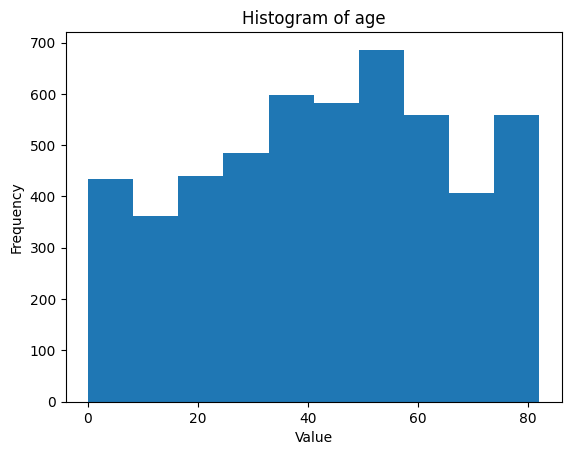

Column: hypertension
Mean: 0.0974559686888454
Standard deviation: 0.29660667423379117
Skewness: 2.7153916581245294
Kurtosis: 5.375455600474597


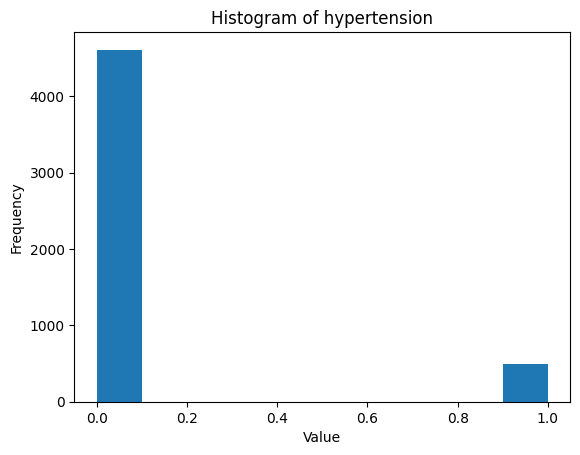

Column: heart_disease
Mean: 0.05401174168297456
Standard deviation: 0.22606298750336543
Skewness: 3.947243966661894
Kurtosis: 13.586052216807259


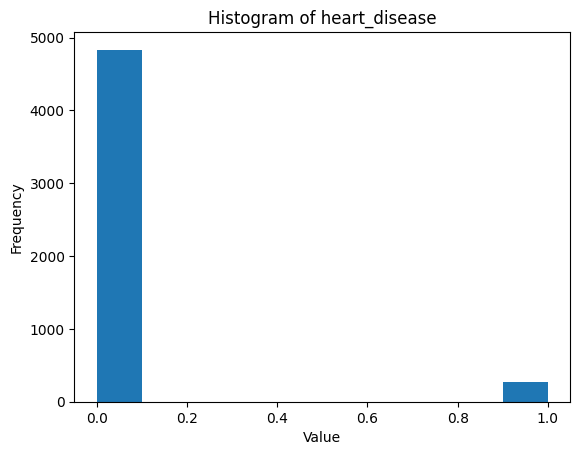

Column: avg_glucose_level
Mean: 106.1476771037182
Standard deviation: 45.28356015058198
Skewness: 1.5722838665030459
Kurtosis: 1.6804785404038278


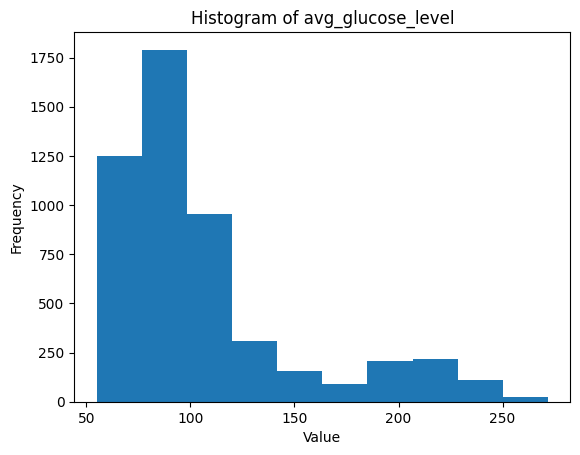

Column: bmi
Mean: 28.893236911794666
Standard deviation: 7.854066729680164
Skewness: 1.0553402052962912
Kurtosis: 3.3626591656236746


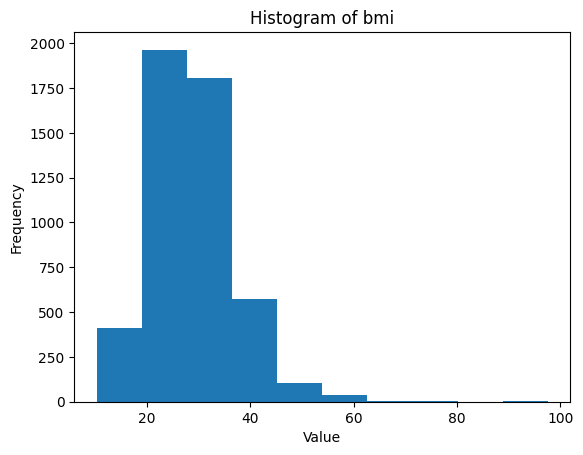

In [24]:
# Identify the numerical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64','uint8']).columns

# Loop through the numerical columns and find the distribution of each column
for col in numerical_cols:
    # Calculate the mean, standard deviation, skewness, and kurtosis
    mean = data[col].mean()
    std = data[col].std()
    skew = data[col].skew()
    kurt = data[col].kurtosis()

    # Print the results
    print(f"Column: {col}")
    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")
    print(f"Skewness: {skew}")
    print(f"Kurtosis: {kurt}")

    # Create a histogram
    plt.hist(data[col])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

We can see that the distributions make sense. So we can move on to determining outliers.




In [33]:
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.01)
nomerical_df = df[['bmi','avg_glucose_level','heart_disease','hypertension', 'age']]
# Fit the model to the data
model.fit(nomerical_df)

# Predict the outlier scores for each data point
outlier_scores = model.predict(nomerical_df)

# Identify the data points with the highest outlier scores
outliers = nomerical_df[outlier_scores == -1]

# Print the outliers
print(outliers)




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


            bmi  avg_glucose_level  heart_disease  hypertension   age
27    30.500000             252.72              1             0  80.0
96    30.900000             216.94              1             1  71.0
153   27.900000             215.94              1             1  82.0
158   31.100000             271.74              1             1  68.0
164   31.500000             175.29              1             1  80.0
180   40.000000             210.40              1             1  55.0
182   28.100000             250.89              1             1  81.0
204   40.500000             247.51              1             1  68.0
218   54.600000             205.84              0             1  74.0
309   30.000000             200.28              1             1  79.0
340   41.900000             109.51              1             1  53.0
388   54.700000              72.79              1             0  52.0
423   60.200000             170.05              0             1  61.0
666   57.500000     

We see strange things like BMI values larger then 60. We will see if removing this values will make our model perform better.

Lets start with the full dataset. first we split the data to train and test.

In [36]:
from sklearn.model_selection import train_test_split

# Separate features and target
features = df.drop('stroke', axis=1)
target = df['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Print the number of samples in each set
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 4088
Number of testing samples: 1022


I want to use and ensemble model that uses Random Forest and Support Vector Machine regressor with RBF kernel - two of the best models for reggration problems.

In [40]:
# Create a Random Forest regressor
rf = RandomForestRegressor()

# Create a Support Vector Machine regressor with RBF kernel
svm = SVR(kernel='rbf')


# Define the hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Create the GridSearchCV objects for each model
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5)

# Fit the GridSearchCV objects to the training data
rf_grid_search.fit(X_train, y_train)
svm_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_rf_params = rf_grid_search.best_params_
best_svm_params = svm_grid_search.best_params_

# Create new models with the best hyperparameters
rf_best = RandomForestRegressor(**best_rf_params)
svm_best = SVR(**best_svm_params)

# Combine the two models using a voting ensemble
ensemble = VotingRegressor(estimators=[('rf', rf_best), ('svm', svm_best)])

# Fit the ensemble model to the training data
ensemble.fit(X_train, y_train)

# Evaluate the ensemble model on the test data
ensemble_score = ensemble.score(X_test, y_test)

# Print the ensemble score
print(f"Ensemble score: {ensemble_score}")

Ensemble score: 0.07945152937384026


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)

# Fit the new model to the training data
rf_best.fit(X_train, y_train)

# Evaluate the new model on the test data
rf_best_score = rf_best.score(X_test, y_test)

# Print the new model score
print(f"Random Forest (best) score: {rf_best_score}")

Random Forest (best) score: 0.9461839530332681


F1 score: 0.0


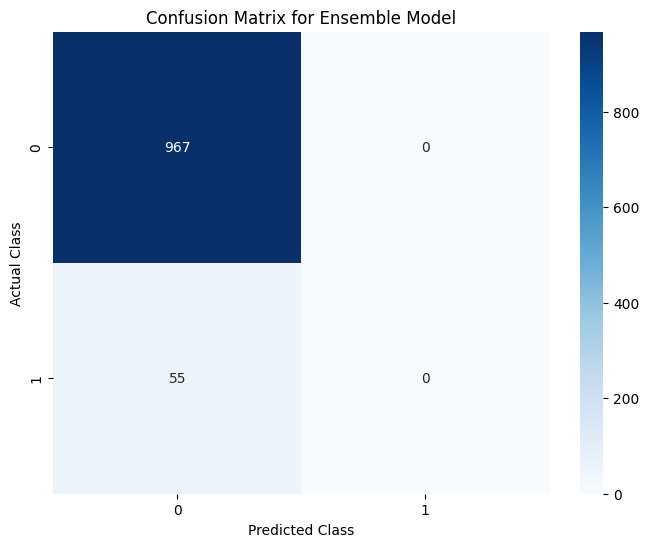

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the classes for the test data using the ensemble model
y_pred = rf_best.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix for Ensemble Model")
plt.show()

In [49]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the F1 score
print(f"F1 score: {f1}")

F1 score: 0.0
